# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Dan Miller

### Github Link: [DMill31](https://github.com/DMill31/article-summarizer)

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

In [64]:
from collections import Counter
import pickle
import requests
import spacy
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

!pip list

print('All prereqs installed.')

Package                   Version
------------------------- --------------
annotated-types           0.7.0
anyio                     4.9.0
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
blis                      1.3.0
catalogue                 2.0.10
certifi                   2025.7.14
cffi                      1.17.1
charset-normalizer        3.4.2
click                     8.2.1
cloudpathlib              0.21.1
colorama                  0.4.6
comm                      0.2.3
comtypes                  1.4.11
confection                0.1.5
contourpy                 1.3.3
cycler                    0.12.1
cymem                     2.0.11
debugpy                   1.8.15
decorator                 5.2.1
defusedxml                0.7.1
en_core_web_s

## Question 1.

1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [65]:
url = 'https://www.mhsmentor.com/16888/opinions/performative-existence-not-a-good-way-to-live/'

response = requests.get(url)
parser = 'html.parser'

soup = BeautifulSoup(response.text, parser)

# Get the title
title_tag = soup.find('h1', class_= 'sno-story-headline')
title = title_tag.get_text(strip=True) if title_tag else None

# Get the body content
body_container = soup.find('div', class_='entry-content') or soup.find('div', class_='post-content') or soup.find('article')
if not body_container:
    body_paragraphs = soup.find_all('p')
else:
    body_paragraphs = body_container.find_all('p')

# Create body with paragraphs 1 through 8
if len(body_paragraphs) > 8:
    body_paragraphs = body_paragraphs[:8]


# Join the text of the paragraphs into a single string
body = '\n\n'.join(p.get_text(strip=True) for p in body_paragraphs if p.get_text(strip=True))

# Print the first 500 characters of the body
print(body[:500])

# Create article
article = {
    'title': title,
    'body': body,
    'url': url
}

# Dump the article to a .pkl
with open('article_body.pkl', 'wb') as f:
    pickle.dump(article, f)


Our perception of what it means to actually live has become skewed. People nowadays tend to live vicariously through others’ lives instead of living for themselves. We tend to pay the most attention to the people’s lives that seem effortless yet carefully constructed. We hear constantly about how we need to become better people. More confident, more good looking, more intelligent, etc. And while we may put those things into practice, the outward view of them is a deception or can only last so lo


## Question 2.

2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [66]:
with open('article_body.pkl', 'rb') as f:
    article = pickle.load(f)

body = article['body']

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

doc = nlp(body)

# Print the number of sentences in the body
sentences = list(doc.sents)
print(f'Number of sentences in body: {len(sentences)}')

# Print polarity of body
polarity = doc._.blob.polarity
print(f'Polarity of body: {polarity}')



Number of sentences in body: 31
Polarity of body: 0.23463976499690786


## Question 3.

3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [67]:
def we_care_about(token):
    return not (token.is_space or token.is_punct or token.is_stop)

interesting_tokens = [token.text.lower() for token in doc if we_care_about(token)]

token_freq = Counter(map(str, interesting_tokens))
print(f'Top 5 most common tokens: {token_freq.most_common(5)}')

Top 5 most common tokens: [('people', 8), ('things', 7), ('good', 5), ('think', 4), ('life', 4)]


## Question 4.

4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [68]:
interesting_lemmas = [token.lemma_.lower() for token in doc if we_care_about(token)]

lemma_freq = Counter(map(str, interesting_lemmas))
print(f'Top 5 most common lemmas: {lemma_freq.most_common(5)}')

Top 5 most common lemmas: [('thing', 9), ('people', 8), ('life', 6), ('good', 5), ('think', 5)]


## Question 5.

5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

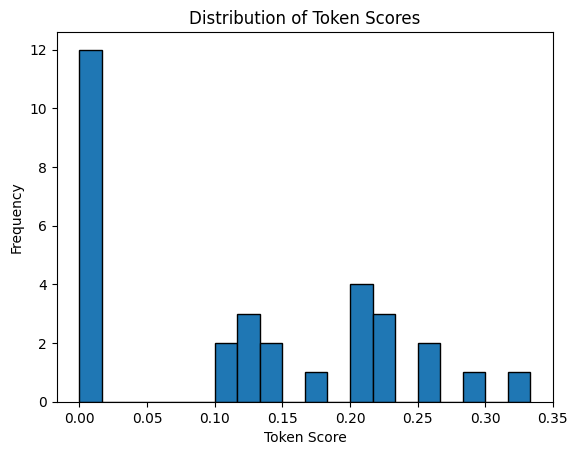

In [69]:
def score_sentence_by_token(sentence, interesting_tokens):
    """
    Score a sentence based on the frequency of interesting tokens.
    Args:
        sentence (spacy.tokens.Span): The sentence to score.
        interesting_tokens (set): A set of tokens considered interesting.
    
    Returns the number of times that any of the interesting tokens appear in the sentence divided by the number of words in the sentence.
    """
    doc = nlp(sentence)
    words = [token.text.lower() for token in doc if we_care_about(token)]
    if not words:
        return 0
    interesting_words = sum(1 for word in words if word in interesting_tokens)
    return interesting_words / len(words)

token_scores = []
for sent in doc.sents:
    token_scores.append(score_sentence_by_token(sent.text, [t[0] for t in token_freq.most_common(5)]))

# Create a histogram of the token scores
plt.hist(token_scores, bins=20, edgecolor='black')
plt.title('Distribution of Token Scores')
plt.xlabel('Token Score')
plt.ylabel('Frequency')
plt.show()

# Just less than 40% of the sentences have a token score of 0.0
# The most common range of token scores seems to be between 0.0 and 0.2, with less than 5 scoring higher

## Question 6.

6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

## Question 7.

7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): 
* Cutoff Score (lemmas):

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

## Question 8.

8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

## Question 9.

9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

## Question 10.

10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

## Question 11.

11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

## Question 12.

12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

## Question 13.

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?